In [27]:
import jax.numpy as jnp
import project_2 as p2
import seaborn as sns
from tqdm import tqdm
import imp
imp.reload(p2)
sns.set(context='talk',style='darkgrid')

# Problem setup:

## States:

$$
x(t) = \left[ 
        \Re\{\bar{V}_1(t)\},
        \Im\{\bar{V}_1(t)\},
        c_g(t),
        s_g(t),
        \delta_g(t),
        \omega_g(t),
        \Re\{\bar{V}_2(t)\},
        \Im\{\bar{V}_2(t)\},
        c_m(t),
        s_m(t),
        \delta_m(t),
        \omega_m(t)
    \right]^T
$$

## System Parameters and Initial Conditions:

In [4]:
#Initial conditions
Ig = 0.75 * jnp.exp(jnp.deg2rad(180)*1j)
Eg = 1.0315 * jnp.exp(jnp.deg2rad(14.2)*1j)
Im = 0.75 #* np.exp(0*1j)
Em = 1/(p2.bm*-1j)*(-1*Im) +1
Pgm = 0.75
Pmm = 0.75
V1 = 1/(p2.b*-1j)*Im + 1
V2 = 1.0*jnp.exp(0*1j)

#Parameters that were not stated anywhere in the project.
omega0 = 2*jnp.pi*60


## Measurements 

In [5]:
measurements  = jnp.array([[1.000, 0.100, 1.000, 0.000, 0.750, 0.000, -0.750, 0.000,-0.750, 0.000, 0.750, 0.000, 0.000, 0.000],
                          [1.000, 0.100, 1.000, 0.000, 0.750, 0.000, -0.750, 0.000, -0.750, 0.000, 0.750, 0.000, 0.000, 0.000,],
                          [0.993, 0.030, 0.987, -0.114, 1.079, -0.041, -1.079, 0.041, -1.079, 0.041, 0.141, 0.068, -0.392, -1.092],
                          [0.991, 0.013, 0.983, -0.135, 1.111, -0.060, -1.111, 0.060, -1.111, 0.060, 0.177, 0.068, -0.811, -2.146],
                          [0.988, -0.014, 0.975, -0.169, 1.160, -0.095, -1.160, 0.095,-1.160, 0.095, 0.233, 0.065, -1.278, -3.125],
                          [0.982, -0.052, 0.963, -0.215, 1.219, -0.148, -1.219, 0.148,-1.219, 0.148, 0.305, 0.056, -1.813, -4.001],
                          [0.974, -0.101, 0.944, -0.271, 1.281, -0.222, -1.281, 0.222, -1.281, 0.222, 0.384, 0.036, -2.425, -4.757],
                          [0.960, -0.159, 0.918, -0.337, 1.335, -0.318, -1.335, 0.318, -1.335, 0.318, 0.464, 0.002, -3.118, -5.387],
                          [0.941, -0.226, 0.883, -0.409, 1.372, -0.436, -1.372, 0.436, -1.372, 0.436, 0.534, -0.047, -3.888, -5.896],
                          [0.915, -0.302, 0.838, -0.487, 1.382, -0.572, -1.382, 0.572, -1.382, 0.572, 0.586, -0.110, -4.723, -6.300],
                          [0.916, -0.334, 0.844, -0.482, 1.106, -0.538, -1.106, 0.538, -1.106, 0.538, 1.106, -0.538, -5.609, -6.622],
                          [0.877, -0.424, 0.790, -0.565, 1.055, -0.652, -1.055, 0.652, -1.055, 0.652, 1.055, -0.652, -6.175, -5.836],
                          [0.832, -0.512, 0.734, -0.640, 0.959, -0.735, -0.959, 0.735, -0.959, 0.735, 0.959, -0.735, -6.730, -5.067],
                          [0.780, -0.597, 0.676, -0.707, 0.828, -0.778, -0.828, 0.778, -0.828, 0.778, 0.828, -0.778, -7.226, -4.377]
                         ])

In [6]:
P = 1e6*jnp.eye(8)
W = (1/(0.01**2))*jnp.eye(measurements.shape[1])

## Dynamic State Estimation

In [10]:
x_k = jnp.array([jnp.real(V1),jnp.imag(V1),jnp.cos(jnp.angle(Eg)),jnp.sin(jnp.angle(Eg)),jnp.angle(Eg),0,jnp.real(V2),jnp.imag(V2),jnp.cos(jnp.angle(Em)),jnp.sin(jnp.angle(Em)),jnp.angle(Em),0])
print(x_k)

[ 1.          0.1         0.96944535  0.2453074   0.24783677  0.
  1.          0.          0.99174285 -0.12824261 -0.12859675  0.        ]


In [11]:
print(p2.g_cons(x_k,x_k))

[-2.0358711e-06  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -9.3132257e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [12]:
jnp.abs(p2.Em)

DeviceArray(1.0083259, dtype=float32, weak_type=True)

In [13]:
X = []
tol = 1e-6
k = 0
# z = measurements[0,:]
# H = p2.measurement_jacobian(x_k)
# G = p2.constraint_jacobian(x_k,x_k)
# d = d_vec(x_k,x_k,z)
#x_k = update_rule(x_k,H,G,W,P,d)
x_k_h = x_k

In [14]:
g = p2.g_cons(x_k,x_k_h)
print(g)

[-2.0358711e-06  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -9.3132257e-10  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [15]:
x_k

DeviceArray([ 1.        ,  0.1       ,  0.96944535,  0.2453074 ,
              0.24783677,  0.        ,  1.        ,  0.        ,
              0.99174285, -0.12824261, -0.12859675,  0.        ],            dtype=float32)

In [17]:
def d_vec(x_k,x_k_h,z):
    h_x = p2.h(x_k)-z
    g_x_k = p2.g_cons(x_k,x_k_h)
    d = jnp.concatenate([h_x,g_x_k])
    return d

def update_rule(x_k,H,G,W,P,d):
    x_k_1 = x_k - jnp.linalg.inv(H.T@W@H + G.T@P@G)@(jnp.hstack([H.T@W,G.T@P]))@d
    return x_k_1


In [18]:

for z,t in enumerate(measurements):
    print("==============================t= ",t)
    for i in tqdm(range(10)):
        
        #print(x_k)
        H = p2.measurement_jacobian(x_k)
        G = p2.constraint_jacobian(x_k,x_k_h)
        #print(H,G)
        d = d_vec(x_k,x_k_h,z)
        x_k = update_rule(x_k,H,G,W,P,d)
       
        #print(d[14:])
    print(x_k)
    X.append(x_k)
    x_k_h = x_k

==============================t=  [ 1.    0.1   1.    0.    0.75  0.   -0.75  0.   -0.75  0.    0.75  0.
  0.    0.  ]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]


[ 0.9561764   0.0535265   0.9608501   0.20577997  0.24759288 -0.02926583
  0.9572143   0.02014398  0.9809521  -0.09033933 -0.12835784  0.0286695 ]
==============================t=  [ 1.    0.1   1.    0.    0.75  0.   -0.75  0.   -0.75  0.    0.75  0.
  0.    0.  ]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]


[ 0.8105889   0.28511277  0.9641843   0.18586874  0.25547338  0.97492653
  0.8132102   0.25507355  0.98064625 -0.04006803 -0.11952822  1.0308851 ]
==============================t=  [ 0.993  0.03   0.987 -0.114  1.079 -0.041 -1.079  0.041 -1.079  0.041
  0.141  0.068 -0.392 -1.092]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.01it/s]


[ 0.67484754  0.5367552   0.9773709   0.19296598  0.28035247  2.010565
  0.678897    0.509461    0.989739    0.03091765 -0.09383991  2.0517116 ]
==============================t=  [ 0.991  0.013  0.983 -0.135  1.111 -0.06  -1.111  0.06  -1.111  0.06
  0.177  0.068 -0.811 -2.146]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.09it/s]


[ 0.54657376  0.8114325   0.9988009   0.22651465  0.3224939   3.0464063
  0.5518462   0.78626275  1.0050911   0.12326267 -0.05112089  3.0745711 ]
==============================t=  [ 0.988 -0.014  0.975 -0.169  1.16  -0.095 -1.16   0.095 -1.16   0.095
  0.233  0.065 -1.278 -3.125]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]


[0.42249602 1.1089733  1.0253502  0.28613475 0.38190916 4.083422
 0.42866215 1.0854152  1.0224787  0.23745033 0.00866394 4.099608  ]
==============================t=  [ 0.982 -0.052  0.963 -0.215  1.219 -0.148 -1.219  0.148 -1.219  0.148
  0.305  0.056 -1.813 -4.001]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.12it/s]


[0.29812634 1.4291586  1.0523688  0.3715344  0.4586251  5.1224923
 0.3047791  1.4067664  1.0365198  0.37363848 0.08554856 5.126547  ]
==============================t=  [ 0.974 -0.101  0.944 -0.271  1.281 -0.222 -1.281  0.222 -1.281  0.222
  0.384  0.036 -2.425 -4.757]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.10it/s]


[0.16778329 1.7714118  1.0737487  0.48205423 0.55267817 6.1638746
 0.17447312 1.7497699  1.0406781  0.5312759  0.17955798 6.1545815 ]
==============================t=  [ 9.600e-01 -1.590e-01  9.180e-01 -3.370e-01  1.335e+00 -3.180e-01
 -1.335e+00  3.180e-01 -1.335e+00  3.180e-01  4.640e-01  2.000e-03
 -3.118e+00 -5.387e+00]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.02it/s]


[0.02467804 2.1344106  1.0820899  0.6161239  0.66410273 7.207072
 0.03094086 2.1131043  1.0274115  0.70864606 0.2906985  7.182281  ]
==============================t=  [ 0.941 -0.226  0.883 -0.409  1.372 -0.436 -1.372  0.436 -1.372  0.436
  0.534 -0.047 -3.888 -5.896]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.14it/s]


[-0.13889329  2.5156476   1.06904     0.7706671   0.7929176   8.25071
 -0.13351086  2.4942417   0.9885176   0.90237314  0.41894668  8.2074995 ]
==============================t=  [ 0.915 -0.302  0.838 -0.487  1.382 -0.572 -1.382  0.572 -1.382  0.572
  0.586 -0.11  -4.723 -6.3  ]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.20it/s]


[-0.3311929   2.9109488   1.0258863   0.9405153   0.93911034  9.292419
 -0.32710814  2.8889725   0.9157373   1.1069517   0.5642366   9.22729   ]
==============================t=  [ 0.916 -0.334  0.844 -0.482  1.106 -0.538 -1.106  0.538 -1.106  0.538
  1.106 -0.538 -5.609 -6.622]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.22it/s]


[-0.5604415   3.3139675   0.94445944  1.1179277   1.1026199  10.328723
 -0.55800974  3.2909074   0.80164826  1.3143917   0.72644573 10.237803  ]
==============================t=  [ 0.877 -0.424  0.79  -0.565  1.055 -0.652 -1.055  0.652 -1.055  0.652
  1.055 -0.652 -6.175 -5.836]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.19it/s]


[-0.833889    3.7157147   0.81836563  1.2923542   1.2833172  11.354954
 -0.833375    3.6910152   0.6408494   1.514103    0.9053794  11.234237  ]
==============================t=  [ 0.832 -0.512  0.734 -0.64   0.959 -0.735 -0.959  0.735 -0.959  0.735
  0.959 -0.735 -6.73  -5.067]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]


[-1.1564747   4.104264    0.64449     1.4506161   1.480986   12.365303
 -1.1580255   4.077341    0.43136477  1.6931691   1.1007557  12.210919  ]
==============================t=  [ 0.78  -0.597  0.676 -0.707  0.828 -0.778 -0.828  0.778 -0.828  0.778
  0.828 -0.778 -7.226 -4.377]


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.11it/s]

[-1.5290797   4.4648876   0.42459497  1.577683    1.6953067  13.353181
 -1.5327046   4.4351587   0.17609145  1.8371583   1.3121947  13.161761  ]


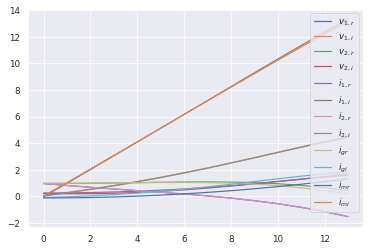

In [20]:
import matplotlib.pyplot as plt
X = jnp.asarray(X)
names = ['$v_{1,r}$','$v_{1,i}$','$v_{2,r}$','$v_{2,i}$','$i_{1,r}$','$i_{1,i}$','$i_{2,r}$','$i_{2,i}$','$i_{gr}$','$i_{gi}$','$i_{mr}$','$i_{mi}$','$\omega_g$','$\omega_m$']
for i in range(12):
    name = names[i]
    plt.plot(X[:,i],label=name)
plt.legend()

Text(0.5, 1.0, 'Voltage Mags and Angles. ')

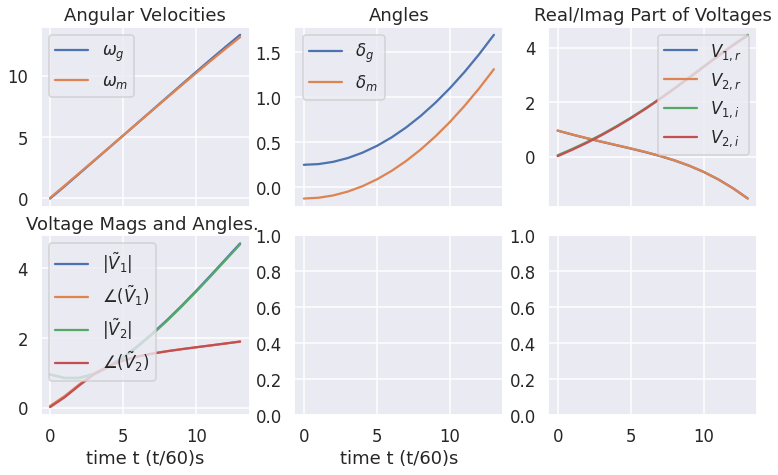

In [29]:
figscale = 3
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(figscale*3.5,figscale*3.5/1.61828),constrained_layout=True,sharex=True)
axes[1,0].set_xlabel("time t (t/60)s")
axes[1,1].set_xlabel("time t (t/60)s")

#Generator and motor speed
axes[0,0].plot([p2.omegag(x) for x in X],label="$\omega_g$")
axes[0,0].plot([p2.omegam(x) for x in X],label="$\omega_m$")
axes[0,0].legend()
axes[0,0].set_title("Angular Velocities")
#Deltas
axes[0,1].plot([p2.deltag(x) for x in X],label="$\delta_g$")
axes[0,1].plot([p2.deltam(x) for x in X],label="$\delta_m$")
axes[0,1].legend()
axes[0,1].set_title("Angles")
#Voltages
axes[0,2].plot([p2.v1r(x) for x in X],label="$V_{1,r}$")
axes[0,2].plot([p2.v2r(x) for x in X],label="$V_{2,r}$")
axes[0,2].plot([p2.v1i(x) for x in X],label="$V_{1,i}$")
axes[0,2].plot([p2.v2i(x) for x in X],label="$V_{2,i}$")
axes[0,2].legend()
axes[0,2].set_title("Real/Imag Part of Voltages")

#Currents
axes[1,0].plot([jnp.abs(p2.v1r(x) + p2.v1i(x)*1j) for x in X],label=r"$|\tilde{V}_1|$")
axes[1,0].plot([jnp.angle(p2.v1r(x) + p2.v1i(x)*1j) for x in X],label=r"$\angle(\tilde{V}_1)$")
axes[1,0].plot([jnp.abs(p2.v2r(x) + p2.v2i(x)*1j) for x in X],label=r"$|\tilde{V}_{2}|$")
axes[1,0].plot([jnp.angle(p2.v2r(x) + p2.v2i(x)*1j)for x in X],label=r"$\angle(\tilde{V}_{2})$")
axes[1,0].legend()
axes[1,0].set_title("Voltage Mags and Angles. ")


In [80]:
print(X[0])

[ 0.99652762  0.09944135  0.96483151  0.26284665  0.26603139  0.98236367
  0.99677504 -0.00453833  0.98927001 -0.14607636 -0.14665903 -0.91990502]
